In [92]:
# import libraries
import torch
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split,KFold
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.linear_model import LinearRegression
import numpy as np
import torch.nn as nn
from tqdm.auto import trange, tqdm
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader


In [93]:
# Load the data
tensile_df =  pd.read_excel("../Tensile_Properties_Data.xlsx", header=0, skiprows=1)
tensile_df

,Reference,Material,Material Group,C (wt.%),Si (wt.%),Mn (wt.%),P (wt.%),S (wt.%),Ni (wt.%),Cr (wt.%),...,Width (mm),Aspect Ratio (L/W),Aspect Ratio (R/W),Aspect Ratio (T/W),Test Temperature (C),Strain Rate (1/s),Yield Strength (MPa),Ultimate Tensile Strength (MPa),Uniform Elongation (%),Total Elongation (%)
0,1,SS304L,"NSM, Rector Internals",0.02,0.45,1.30,NaN,NaN,8.02,18.30,...,1.2,4.166700,1.1667,0.625000,23.0,0.001000,274.0,789.0,67.00,76.00
1,1,SS304L,"NSM, Rector Internals",0.02,0.45,1.30,NaN,NaN,8.02,18.30,...,0.8,4.437500,0.3750,0.500000,23.0,0.001000,272.0,781.0,69.00,80.00
2,1,FeCrAl,"NSM, Fuel Cladding",NaN,0.13,NaN,NaN,NaN,NaN,13.10,...,1.2,4.166700,1.1667,0.416667,23.0,0.001000,710.0,767.0,7.90,14.80
3,1,FeCrAl,"NSM, Fuel Cladding",NaN,0.13,NaN,NaN,NaN,NaN,13.10,...,0.8,3.187500,0.3750,0.500000,23.0,0.001000,607.0,760.0,10.80,23.10
4,1,FeCrAl,"NSM, Fuel Cladding",NaN,0.13,NaN,NaN,NaN,NaN,13.10,...,0.8,3.187500,0.3750,0.500000,23.0,0.001000,725.0,782.0,6.60,18.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1468,27,SS316,SS316,0.065,0.31,1.75,0.025,0.0175,13.50,17.00,...,114.0,0.222807,NaN,0.114035,760.0,0.000067,214.0,572.0,59.35,67.66
1469,27,SS316,SS316,0.065,0.31,1.75,0.025,0.0175,13.50,17.00,...,NaN,NaN,NaN,NaN,760.0,0.000067,207.0,494.0,38.80,47.80
1470,27,SS316,SS316,0.065,0.31,1.75,0.025,0.0175,13.50,17.00,...,NaN,NaN,NaN,NaN,760.0,0.003667,101.0,352.0,31.22,47.25
1471,27,SS316,SS316,0.065,0.31,1.75,0.025,0.0175,13.50,17.00,...,25.0,2.032000,NaN,0.000000,760.0,0.000067,177.0,497.0,40.40,46.50


In [94]:
# Check the data information for each column.
tensile_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1473 entries, 0 to 1472
Data columns (total 56 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Reference                        1473 non-null   int64  
 1   Material                         1473 non-null   object 
 2   Material Group                   1473 non-null   object 
 3   C (wt.%)                         1210 non-null   object 
 4   Si (wt.%)                        1174 non-null   float64
 5   Mn (wt.%)                        1179 non-null   float64
 6   P (wt.%)                         1157 non-null   float64
 7   S (wt.%)                         965 non-null    float64
 8   Ni (wt.%)                        1387 non-null   float64
 9   Cr (wt.%)                        1404 non-null   float64
 10  Mo (wt.%)                        1331 non-null   float64
 11  Al (wt.%)                        484 non-null    float64
 12  N (wt.%)            

In [95]:
# Select the composition columns
compostion_cols = tensile_df.columns[3:29]
compostion_cols

Index(['C (wt.%)', 'Si (wt.%)', 'Mn (wt.%)', 'P (wt.%)', 'S (wt.%)',
       'Ni (wt.%)', 'Cr (wt.%)', 'Mo (wt.%)', 'Al (wt.%)', 'N (wt.%)',
       'Ti (wt.%)', 'Fe (wt.%)', 'Nb (wt.%)', 'B (wt.%)', 'Cu (wt.%)',
       'V (wt.%)', 'Mg (wt.%)', 'Y (wt.%)', 'Zr (wt.%)', 'Zn (wt.%)',
       'W (wt.%)', 'Sn (wt.%)', 'Co (wt.%)', 'O (wt.,%)', 'Ta (wt.%)',
       'H (wt.%)'],
      dtype='object')

In [96]:
# Fill the nan values with 0 for the comospition columns
tensile_df[compostion_cols]  = tensile_df[compostion_cols].fillna(0)
tensile_df['Irradiation Dose (mdpa)']  = tensile_df['Irradiation Dose (mdpa)'].fillna(0)
tensile_df['Irradiation Temperature (C)']  = tensile_df['Irradiation Temperature (C)'].fillna(0)

In [97]:
# Displace the latest dataframe information
tensile_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1473 entries, 0 to 1472
Data columns (total 56 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Reference                        1473 non-null   int64  
 1   Material                         1473 non-null   object 
 2   Material Group                   1473 non-null   object 
 3   C (wt.%)                         1473 non-null   object 
 4   Si (wt.%)                        1473 non-null   float64
 5   Mn (wt.%)                        1473 non-null   float64
 6   P (wt.%)                         1473 non-null   float64
 7   S (wt.%)                         1473 non-null   float64
 8   Ni (wt.%)                        1473 non-null   float64
 9   Cr (wt.%)                        1473 non-null   float64
 10  Mo (wt.%)                        1473 non-null   float64
 11  Al (wt.%)                        1473 non-null   float64
 12  N (wt.%)            

In [98]:
# Displace the unique values of the Zr, C and Fe compositions, 
# the initial data collection contains some < signs or ppm, bal, we want to check if these columns have this sign.
print('unique values for Zr (wt.%) column:' + str(tensile_df['Zr (wt.%)'].unique()))
print(100*'_')
print('unique values for C (wt.%) column:' + str(tensile_df['C (wt.%)'].unique()))
print(100*'_')
print('unique values for Fe (wt.%) column:' + str(tensile_df['Fe (wt.%)'].unique()))

unique values for Zr (wt.%) column:[0 98.173 'bal' 1.44]
____________________________________________________________________________________________________
unique values for C (wt.%) column:[0.02 0 0.018 0.01 0.21 0.09 0.055 0.17 0.24 0.07 0.1 0.2 0.14 0.006 0.136
 0.098 0.03 0.18 0.036 '150-400ppm' '<40 ppm' 0.12 0.064 0.061 0.063 0.06
 0.05 0.04 0.058 0.009 0.008 0.014 0.065 0.066 0.053 0.048 0.057 0.039
 0.043 0.041]
____________________________________________________________________________________________________
unique values for Fe (wt.%) column:[71.836 79.41 18.7 0.35 0.2 68.052 57.980000000000004 96.828 90.174
 63.537800000000004 86.78999999999999 97.71 96.978 70.77 96.504 99.13 0
 0.25 86.326 89.53999999999999 67.9 97.1003 94.904 71.089 0.165 '<0.6'
 99.19 64.94000000000001 52.6088 58.8682 66.80699999999999 63.4728 96.843
 67.36000000000001 68.90299999999999 65.57600000000001 64.889 72.245
 70.85600000000001 70.856 67.656 64.6745 66.408 64.62395 66.038 66.252
 65.054 65.15

In [99]:
# Remove the data with <, ppm and bal text in these there columns. 
tensile_df = tensile_df[~tensile_df['Zr (wt.%)'].isin(['<','ppm','bal'])]
tensile_df = tensile_df[~tensile_df['C (wt.%)'].isin(['<','ppm','bal'])]
tensile_df = tensile_df[~tensile_df['Fe (wt.%)'].isin(['<','ppm','bal'])]


In [100]:
# Check the data again, make sure  the data is cleaned.
print('unique values for Zr (wt.%) column:' + str(tensile_df['Zr (wt.%)'].unique()))
print(100*'_')
print('unique values for C (wt.%) column:' + str(tensile_df['C (wt.%)'].unique()))
print(100*'_')
print('unique values for Fe (wt.%) column:' + str(tensile_df['Fe (wt.%)'].unique()))

unique values for Zr (wt.%) column:[0 98.173 1.44]
____________________________________________________________________________________________________
unique values for C (wt.%) column:[0.02 0 0.018 0.01 0.21 0.09 0.055 0.17 0.24 0.07 0.1 0.2 0.14 0.006 0.136
 0.098 0.03 0.18 0.036 0.12 0.064 0.061 0.063 0.06 0.05 0.04 0.058 0.009
 0.008 0.014 0.065 0.066 0.053 0.048 0.057 0.039 0.043 0.041]
____________________________________________________________________________________________________
unique values for Fe (wt.%) column:[71.836 79.41 18.7 0.35 0.2 68.052 57.980000000000004 96.828 90.174
 63.537800000000004 86.78999999999999 97.71 96.978 70.77 96.504 99.13 0
 0.25 86.326 89.53999999999999 67.9 97.1003 94.904 71.089 99.19
 64.94000000000001 52.6088 58.8682 66.80699999999999 63.4728 96.843
 67.36000000000001 68.90299999999999 65.57600000000001 64.889 72.245
 70.85600000000001 70.856 67.656 64.6745 66.408 64.62395 66.038 66.252
 65.054 65.1522 65.0159999999999 65.7088 64.6432 64.9213

In [101]:
# convert all of the composition columns' data type to float.
tensile_df[compostion_cols]  = tensile_df[compostion_cols].astype(float)

In [102]:
# Select all the sub-sized type ss316  samples.
tensile_df  = tensile_df[(tensile_df['Material Group'].str.contains('ss316', case=False))& (tensile_df['Specimen Size'] == 'Sub-sized')]

In [103]:
# Display the latest dataframe information.
tensile_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 556 entries, 21 to 989
Data columns (total 56 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Reference                        556 non-null    int64  
 1   Material                         556 non-null    object 
 2   Material Group                   556 non-null    object 
 3   C (wt.%)                         556 non-null    float64
 4   Si (wt.%)                        556 non-null    float64
 5   Mn (wt.%)                        556 non-null    float64
 6   P (wt.%)                         556 non-null    float64
 7   S (wt.%)                         556 non-null    float64
 8   Ni (wt.%)                        556 non-null    float64
 9   Cr (wt.%)                        556 non-null    float64
 10  Mo (wt.%)                        556 non-null    float64
 11  Al (wt.%)                        556 non-null    float64
 12  N (wt.%)                  

In [104]:
# Drop the columns that don't have  enough data records.
tensile_df = tensile_df.drop(columns=[ 'Reference','Manufacturing','Cooling', 'Material', 'Treatment', 'Specimen Size Type',
                                       'Irradiation Time (h)', 'Fillet Radius (mm)', 'Specimen Size',
                                       'Post Treatment Temperature (C)','Post Treatment Time (h)','Microstructure', 'Aspect Ratio (R/W)', 'Uniform Elongation (%)',
                                       'Yield Strength (MPa)', 'Total Elongation (%)','Specimen Shape'
                                       ])


In [105]:
# Dpsplay the latest dataframe information.
tensile_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 556 entries, 21 to 989
Data columns (total 39 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Material Group                   556 non-null    object 
 1   C (wt.%)                         556 non-null    float64
 2   Si (wt.%)                        556 non-null    float64
 3   Mn (wt.%)                        556 non-null    float64
 4   P (wt.%)                         556 non-null    float64
 5   S (wt.%)                         556 non-null    float64
 6   Ni (wt.%)                        556 non-null    float64
 7   Cr (wt.%)                        556 non-null    float64
 8   Mo (wt.%)                        556 non-null    float64
 9   Al (wt.%)                        556 non-null    float64
 10  N (wt.%)                         556 non-null    float64
 11  Ti (wt.%)                        556 non-null    float64
 12  Fe (wt.%)                 

In [106]:
# Remove nan values from the dataset.
tensile_df = tensile_df.dropna()
tensile_df = tensile_df.reset_index(drop=True)
tensile_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209 entries, 0 to 208
Data columns (total 39 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Material Group                   209 non-null    object 
 1   C (wt.%)                         209 non-null    float64
 2   Si (wt.%)                        209 non-null    float64
 3   Mn (wt.%)                        209 non-null    float64
 4   P (wt.%)                         209 non-null    float64
 5   S (wt.%)                         209 non-null    float64
 6   Ni (wt.%)                        209 non-null    float64
 7   Cr (wt.%)                        209 non-null    float64
 8   Mo (wt.%)                        209 non-null    float64
 9   Al (wt.%)                        209 non-null    float64
 10  N (wt.%)                         209 non-null    float64
 11  Ti (wt.%)                        209 non-null    float64
 12  Fe (wt.%)             

In [107]:
# sort the dataframe by Ultimate Tensile Strength values.
tensile_df = tensile_df.sort_values(by='Ultimate Tensile Strength (MPa)').reset_index(drop=True)

In [108]:
# Select columns for modeling.
input_features_df =  tensile_df.drop(columns=['Ultimate Tensile Strength (MPa)'])

In [109]:
# Encode the categorical columns.
input_features_df['Material Group'] = input_features_df['Material Group'].astype('category')
input_features_df['Material Group'] = input_features_df['Material Group'].cat.codes

input_features_df['Treatment – Three Categories'] = input_features_df['Treatment – Three Categories'].astype('category')
input_features_df['Treatment – Three Categories'] = input_features_df['Treatment – Three Categories'].cat.codes

In [110]:
# make sure all the input data is float data type.
input_features_df = input_features_df.astype('float')

In [111]:
# define the input X and input Y values.
features = input_features_df
targets = tensile_df['Ultimate Tensile Strength (MPa)']

Run # 1 Fold # 1
Pearson CC: 0.9486053025709795
R2 score: 0.893250323408715
RMSE: 50.20307090841145
MAE: 32.887480068409026


c:\Users\LZ\anaconda3\envs\tf-gpu\lib\site-packages\xgboost\core.py:160: UserWarning: [21:09:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


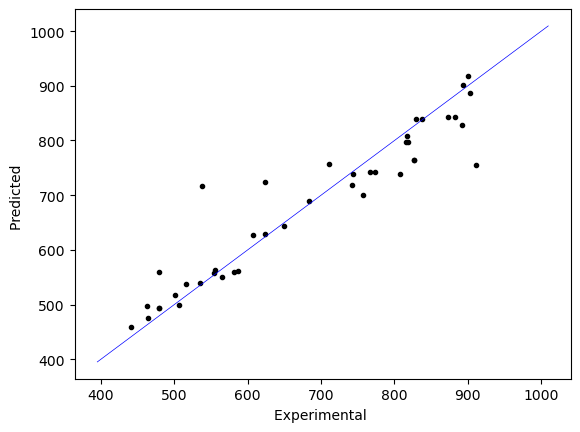

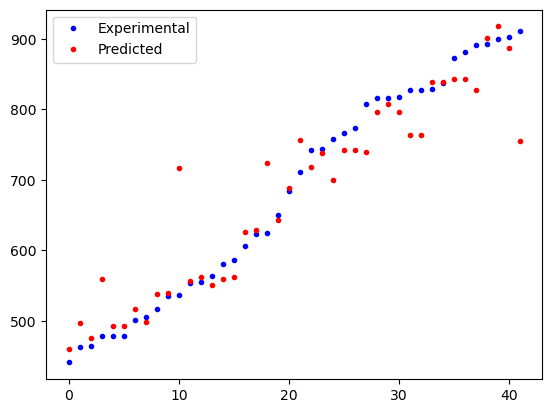

Run # 1 Fold # 2
Pearson CC: 0.9629395600877882
R2 score: 0.922010509144322
RMSE: 33.078645053461045
MAE: 22.562374954183195


c:\Users\LZ\anaconda3\envs\tf-gpu\lib\site-packages\xgboost\core.py:160: UserWarning: [21:09:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


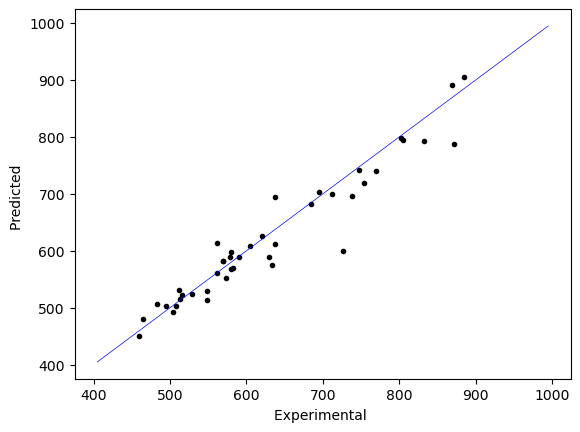

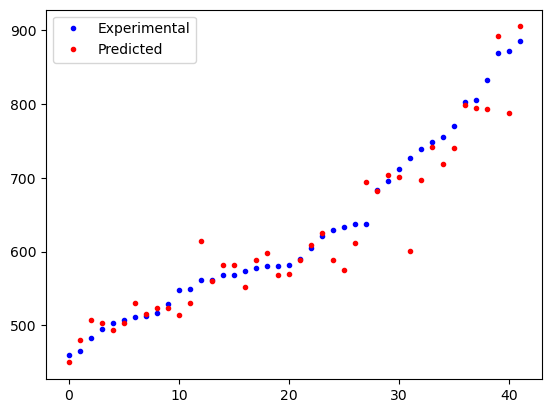

Run # 1 Fold # 3
Pearson CC: 0.9050301532295766
R2 score: 0.8183391677141145
RMSE: 60.731153352297675
MAE: 36.18663896124881


c:\Users\LZ\anaconda3\envs\tf-gpu\lib\site-packages\xgboost\core.py:160: UserWarning: [21:09:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


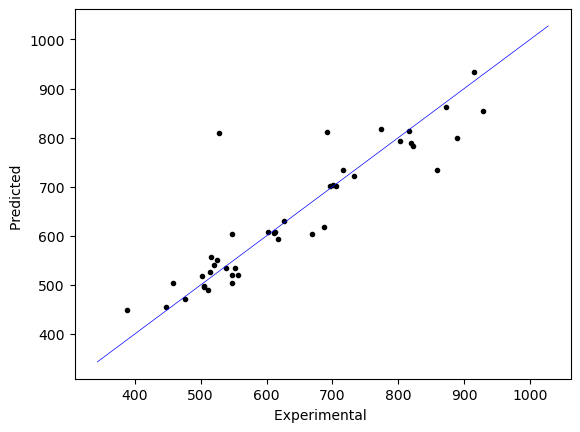

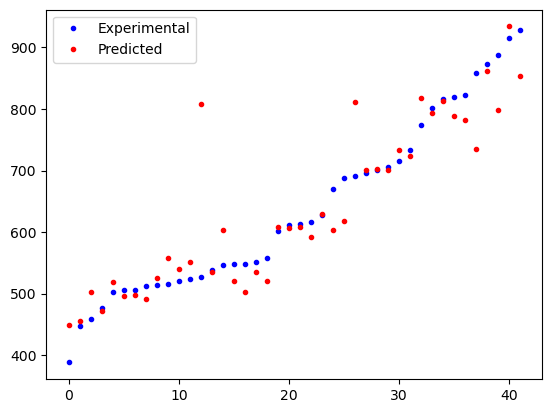

Run # 1 Fold # 4
Pearson CC: 0.8742887218529218
R2 score: 0.7600427433070731
RMSE: 64.37026305021696
MAE: 42.98464185347441


c:\Users\LZ\anaconda3\envs\tf-gpu\lib\site-packages\xgboost\core.py:160: UserWarning: [21:09:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


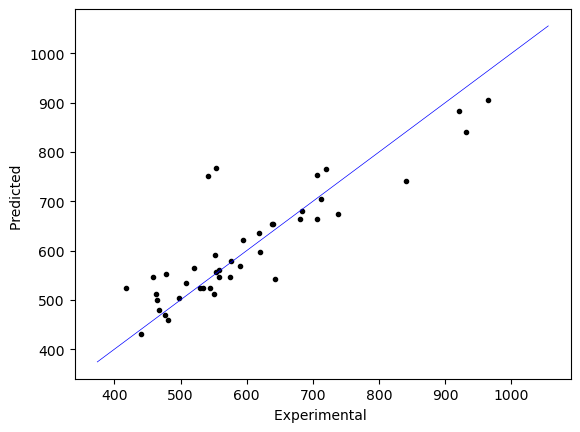

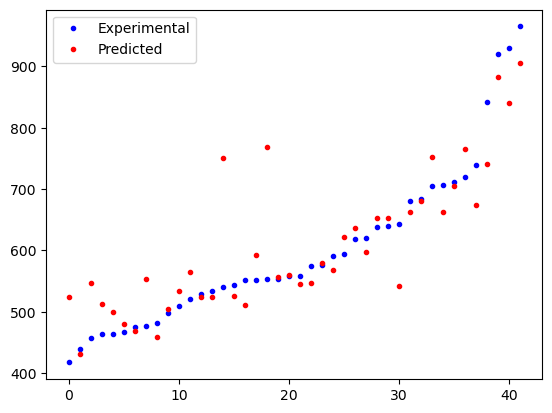

c:\Users\LZ\anaconda3\envs\tf-gpu\lib\site-packages\xgboost\core.py:160: UserWarning: [21:09:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


Run # 1 Fold # 5
Pearson CC: 0.9738655557600351
R2 score: 0.9415230804551041
RMSE: 32.33708110916963
MAE: 24.83476190949919


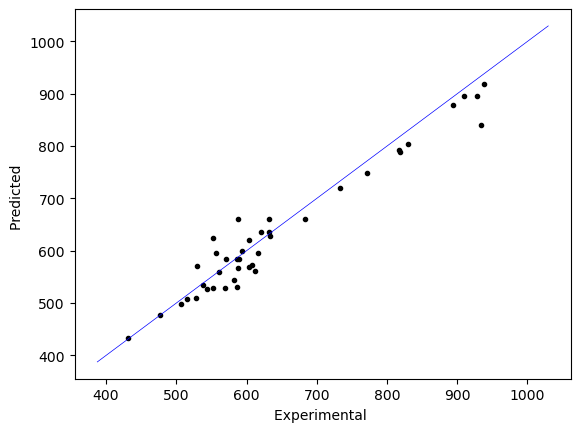

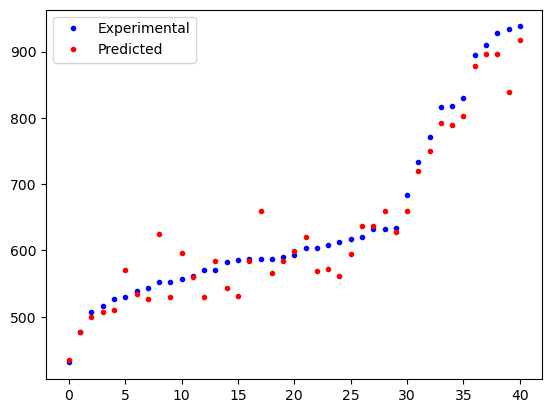

In [112]:
# XGBoost Model with 5 folds cross validation.
import xgboost as xg


nruns = 1
nfolds = 5

PearsonCC = np.zeros((nruns, nfolds))
R2_score = np.zeros_like(PearsonCC)
MSE = np.zeros_like(PearsonCC)
MAE = np.zeros_like(PearsonCC)

for j in range(nruns):

        kf = KFold(n_splits=nfolds, shuffle=True, random_state=123+j)

        for i, (tr, ts) in enumerate(kf.split(targets)):

            # Display the run number
            print('Run #', j+1, "Fold #", i+1)

            x_train, x_test = features.iloc[tr], features.iloc[ts]
            y_train, y_test = targets[tr], targets[ts]

            scale = StandardScaler()
            x_train = scale.fit_transform(x_train)
            x_test = scale.transform(x_test)

            # Initialize LightGBM Regressor
            xgboost_regressor = xg.XGBRegressor(objective ='reg:linear',
                                                colsample_bytree = 0.3,
                                                learning_rate = 0.1,
                                                max_depth = 5,
                                                alpha = 10,
                            n_estimators=100, seed = 123)

            # Train the model
            xgboost_regressor.fit(x_train, y_train)

            # Make predictions on the testing set
            y_pred = xgboost_regressor.predict(x_test)

            # Evaluation
            R2_score[j, i] = r2_score(y_test, y_pred)
            PearsonCC[j, i] =  pearsonr(y_test, np.squeeze(y_pred))[0]
            MSE[j, i] = np.sqrt(mean_squared_error(y_test, y_pred))
            MAE[j, i] = mean_absolute_error(y_test, y_pred)

            print(f'Pearson CC: {PearsonCC[j, i]}')
            print(f'R2 score: {R2_score[j, i]}')
            print(f'RMSE: {MSE[j, i]}')
            print(f'MAE: {MAE[j, i]}')


            # Parity plot, actual versus predicted values
            plt.plot(y_test, y_pred, 'k.')
            bounds = (min(y_test.min(), y_pred.min()) - 0.1*y_pred.min(), max(y_test.max(), y_pred.max())+ 0.1 * y_pred.max())
            plt.plot([bounds[0], bounds[1]], [bounds[0], bounds[1]],'b-', linewidth=0.5, label="Parity Line") # identity line
            plt.xlabel("Experimental ", fontsize=10)
            plt.ylabel("Predicted ", fontsize=10)
            plt.show()

            plt.plot(np.array(y_test), 'b.', label='Experimental')
            plt.plot(np.array(y_pred), 'r.', label='Predicted')
            plt.legend()
            plt.show()

In [113]:
# Summary of the results dataframe
df1 = pd.DataFrame({'Pearson CC': PearsonCC.flatten(), 'R2 Score': R2_score.flatten(), 'MSE': MSE.flatten(),
                    'MAE': MAE.flatten()},index=None)
df1

,Pearson CC,R2 Score,MSE,MAE
0,0.948605,0.893250,50.203071,32.887480
1,0.962940,0.922011,33.078645,22.562375
2,0.905030,0.818339,60.731153,36.186639
3,0.874289,0.760043,64.370263,42.984642
4,0.973866,0.941523,32.337081,24.834762


In [114]:
# Calculate mean values and standard deviations of the scores
PearsonCC_mean = np.mean(PearsonCC)
R2_score_mean = np.mean(R2_score)
MSE_mean = np.mean(MSE)
MAE_mean = np.mean(MAE)

PearsonCC_std = np.std(PearsonCC)
R2_score_std = np.std(R2_score)
MSE_std = np.std(MSE)
MAE_std = np.std(MAE)

# Data frame
df2 = pd.DataFrame({'Pearson CC Mean': PearsonCC_mean, 'Pearson CC Std': PearsonCC_std, 'R2 Score Mean': R2_score_mean, 'R2 Score Std': R2_score_std,
                  'MSE Mean': MSE_mean, 'MSE Std': MSE_std, 'MAE Mean': MAE_mean, 'MAE Std':MAE_std },index=[0])

df2

,Pearson CC Mean,Pearson CC Std,R2 Score Mean,R2 Score Std,MSE Mean,MSE Std,MAE Mean,MAE Std
0,0.932946,0.037521,0.867033,0.067936,48.144043,13.437198,31.89118,7.474331


Run # 1 Fold # 1
Pearson CC: 0.9318919183809378
R2 score: 0.8670613127273575
RMSE: 56.02381672788828
MAE: 33.89510395273629


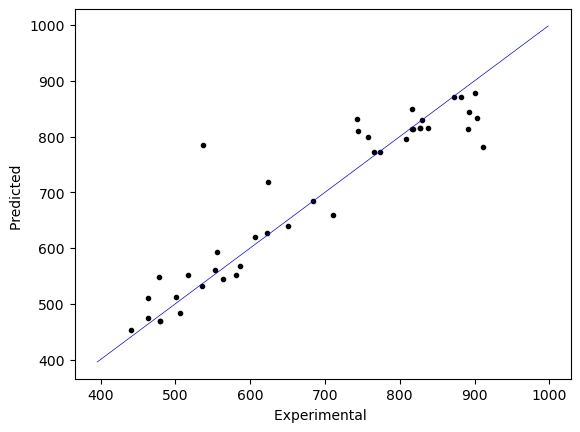

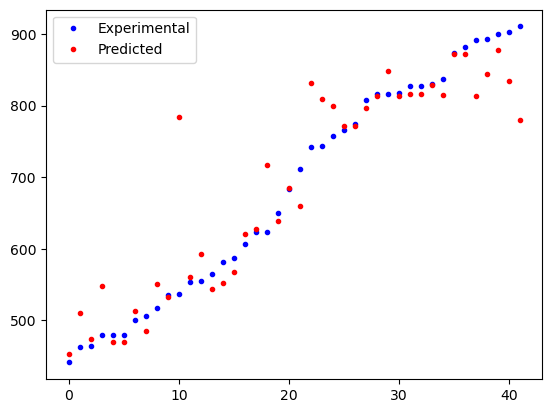

Run # 1 Fold # 2
Pearson CC: 0.939546818113868
R2 score: 0.8767839349544024
RMSE: 41.57797531320824
MAE: 28.89369185179493


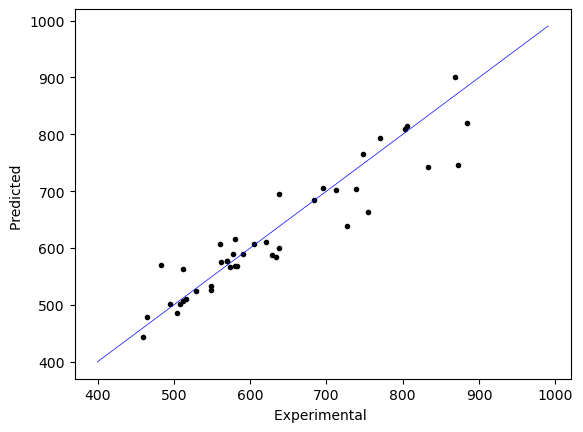

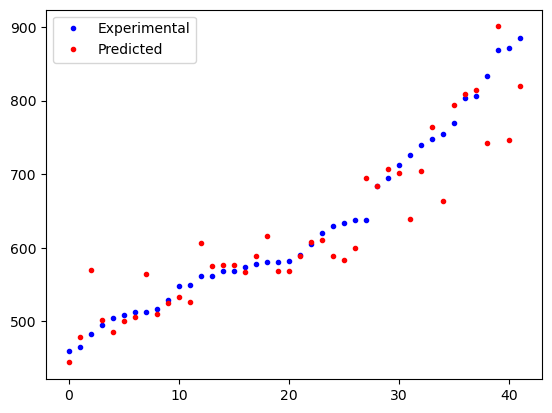

Run # 1 Fold # 3
Pearson CC: 0.9351152721713393
R2 score: 0.873522955488226
RMSE: 50.67418042722045
MAE: 29.63838820374528


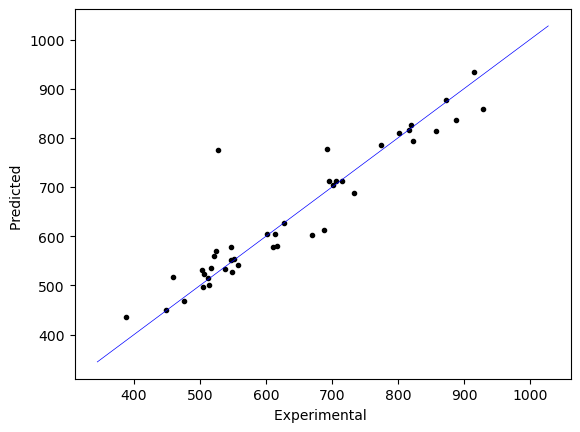

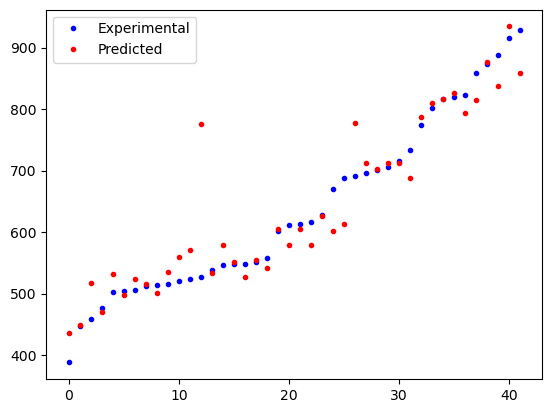

Run # 1 Fold # 4
Pearson CC: 0.8826720058242761
R2 score: 0.75923061427556
RMSE: 64.47910077053443
MAE: 39.47165755380094


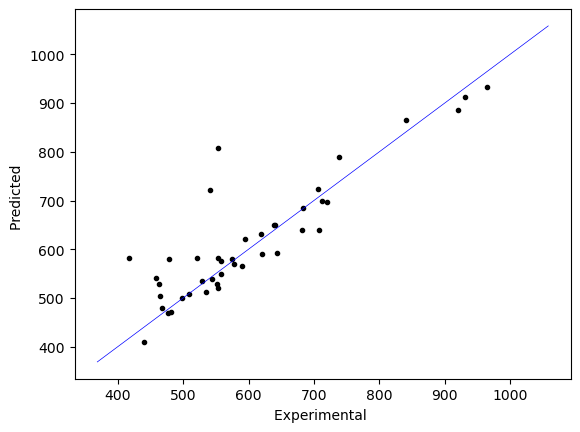

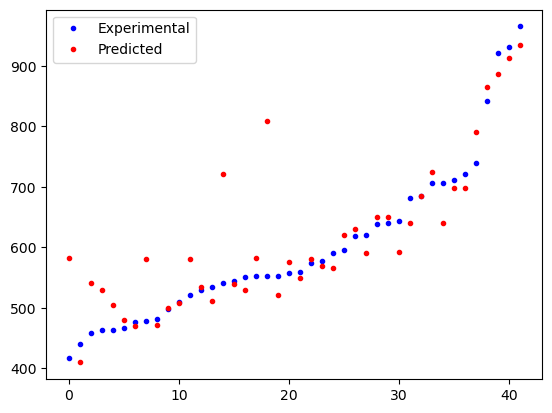

Run # 1 Fold # 5
Pearson CC: 0.9519154237521976
R2 score: 0.8977047155955759
RMSE: 42.769717299636326
MAE: 27.775479455398976


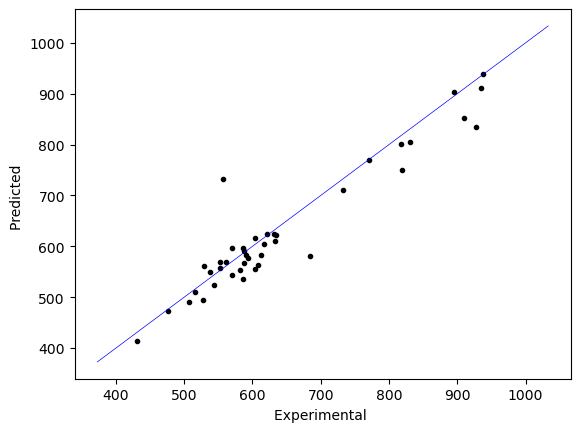

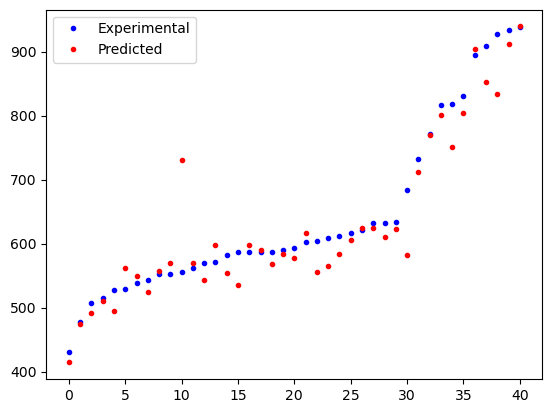

In [115]:
# Gaussian Process Regression Model with 5 folds cross validation.
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, DotProduct, ConstantKernel as C


nruns = 1
nfolds = 5

PearsonCC = np.zeros((nruns, nfolds))
R2_score = np.zeros_like(PearsonCC)
MSE = np.zeros_like(PearsonCC)
MAE = np.zeros_like(PearsonCC)

for j in range(nruns):

        kf = KFold(n_splits=nfolds, shuffle=True, random_state=123+j)
        kernel = C(1.0) * Matern(length_scale=1.0) + WhiteKernel(noise_level=1.0) + C(1.0) * DotProduct(sigma_0=1.0)

        for i, (tr, ts) in enumerate(kf.split(targets)):

            # Display the run number
            print('Run #', j+1, "Fold #", i+1)

            x_train, x_test = features.iloc[tr], features.iloc[ts]
            y_train, y_test = targets[tr], targets[ts]

            scale = MinMaxScaler()
            x_train = scale.fit_transform(x_train)
            x_test = scale.transform(x_test)

            # Initialize GP Regressor
            model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=20, normalize_y=True)

            model.fit(x_train, y_train)

            mu_z, std_z = model.predict(x_test, return_std=True)
            y_pred_test = mu_z
            y_pred_unc_test = std_z

            # Evaluation
            R2_score[j, i] = r2_score(y_test, y_pred_test)
            PearsonCC[j, i] =  pearsonr(y_test, np.squeeze(y_pred_test))[0]
            MSE[j, i] = np.sqrt(mean_squared_error(y_test, y_pred_test))
            MAE[j, i] = mean_absolute_error(y_test, y_pred_test)

            print(f'Pearson CC: {PearsonCC[j, i]}')
            print(f'R2 score: {R2_score[j, i]}')
            print(f'RMSE: {MSE[j, i]}')
            print(f'MAE: {MAE[j, i]}')


            # Parity plot, actual versus predicted values
            plt.plot(y_test, y_pred_test, 'k.')
            bounds = (min(y_test.min(), y_pred_test.min()) - 0.1*y_pred_test.min(), max(y_test.max(), y_pred_test.max())+ 0.1 * y_pred_test.max())
            plt.plot([bounds[0], bounds[1]], [bounds[0], bounds[1]],'b-', linewidth=0.5, label="Parity Line") # identity line
            plt.xlabel("Experimental ", fontsize=10)
            plt.ylabel("Predicted ", fontsize=10)
            plt.show()

            plt.plot(np.array(y_test), 'b.', label='Experimental')
            plt.plot(np.array(y_pred_test), 'r.', label='Predicted')
            plt.legend()
            plt.show()

In [116]:
# Data frame
df1 = pd.DataFrame({'Pearson CC': PearsonCC.flatten(), 'R2 Score': R2_score.flatten(), 'MSE': MSE.flatten(),
                    'MAE': MAE.flatten()},index=None)
df1

,Pearson CC,R2 Score,MSE,MAE
0,0.931892,0.867061,56.023817,33.895104
1,0.939547,0.876784,41.577975,28.893692
2,0.935115,0.873523,50.674180,29.638388
3,0.882672,0.759231,64.479101,39.471658
4,0.951915,0.897705,42.769717,27.775479


In [117]:
# Calculate mean values and standard deviations of the scores
PearsonCC_mean = np.mean(PearsonCC)
R2_score_mean = np.mean(R2_score)
MSE_mean = np.mean(MSE)
MAE_mean = np.mean(MAE)

PearsonCC_std = np.std(PearsonCC)
R2_score_std = np.std(R2_score)
MSE_std = np.std(MSE)
MAE_std = np.std(MAE)

# Data frame
df2 = pd.DataFrame({'Pearson CC Mean': PearsonCC_mean, 'Pearson CC Std': PearsonCC_std, 'R2 Score Mean': R2_score_mean, 'R2 Score Std': R2_score_std,
                  'MSE Mean': MSE_mean, 'MSE Std': MSE_std, 'MAE Mean': MAE_mean, 'MAE Std':MAE_std },index=[0])

df2

,Pearson CC Mean,Pearson CC Std,R2 Score Mean,R2 Score Std,MSE Mean,MSE Std,MAE Mean,MAE Std
0,0.928228,0.023771,0.854861,0.048905,51.104958,8.52629,31.934864,4.300437


Run # 1 Fold # 1
Pearson CC: 0.9393351107769325
R2 score: 0.868537451049398
RMSE: 55.711906936421656
MAE: 32.62927869640769


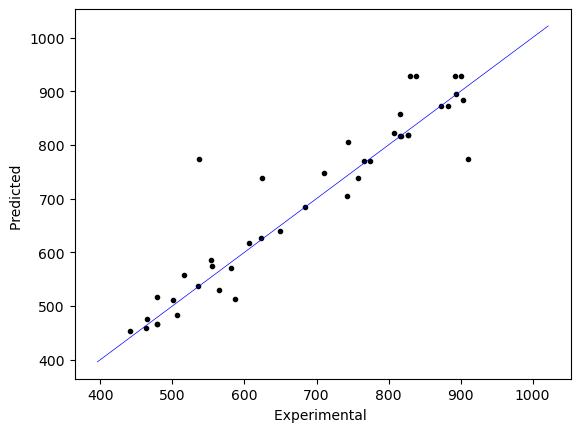

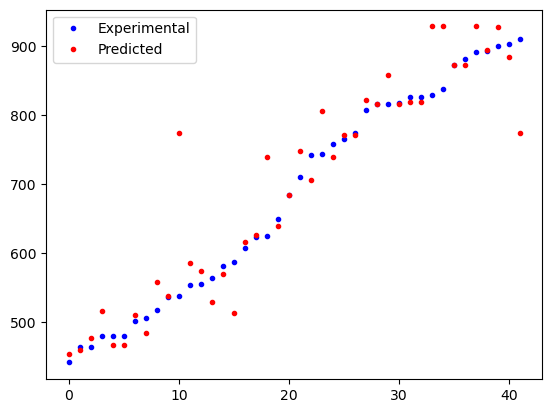

Run # 1 Fold # 2
Pearson CC: 0.9202575446132921
R2 score: 0.8321488266486184
RMSE: 48.52794046214616
MAE: 29.755922088928926


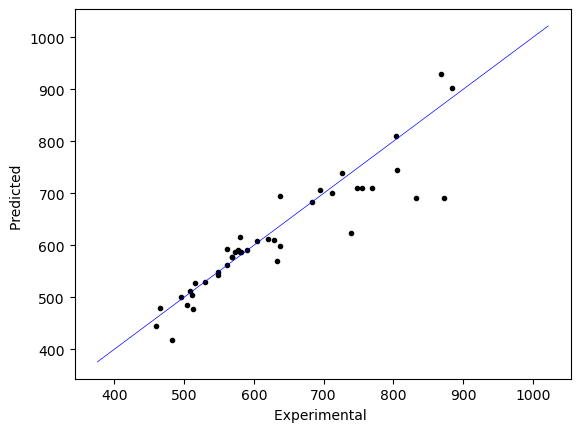

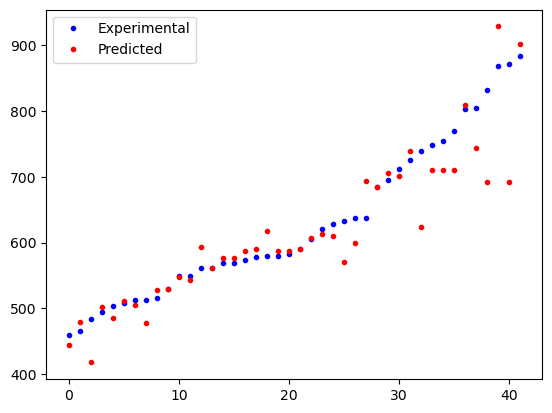

Run # 1 Fold # 3
Pearson CC: 0.9190211198844556
R2 score: 0.8241414072916482
RMSE: 59.75340742282019
MAE: 34.23251616125206


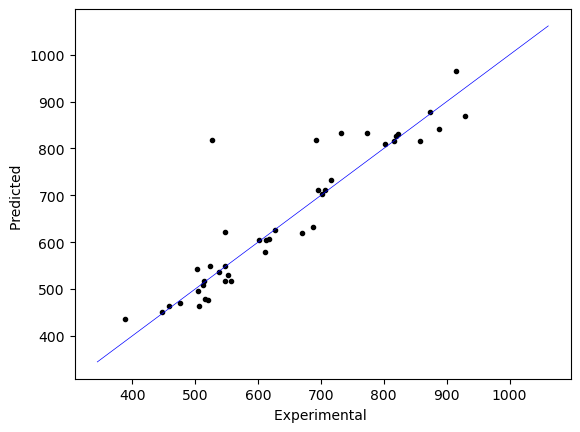

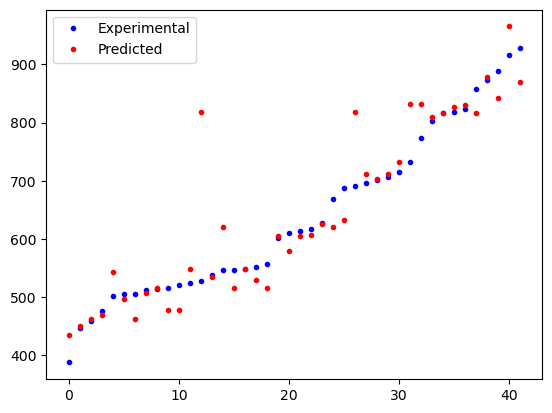

Run # 1 Fold # 4
Pearson CC: 0.9003169932843809
R2 score: 0.8093219038441085
RMSE: 57.38108333014514
MAE: 31.397051337469822


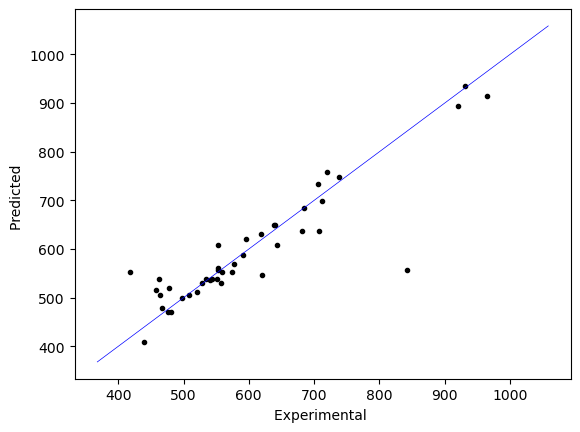

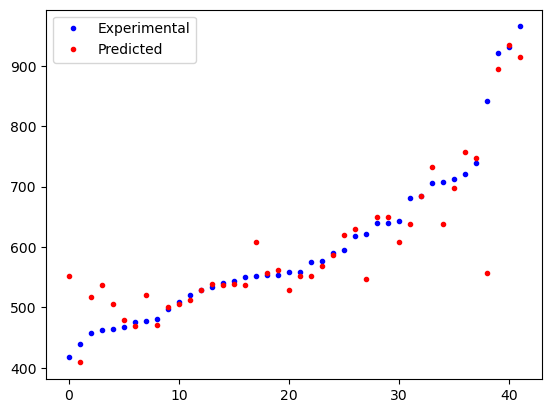

Run # 1 Fold # 5
Pearson CC: 0.9687017350972363
R2 score: 0.9367379230932584
RMSE: 33.63413751534166
MAE: 21.648858290525233


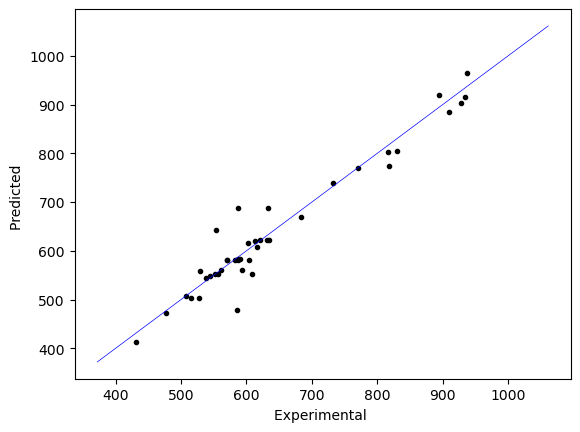

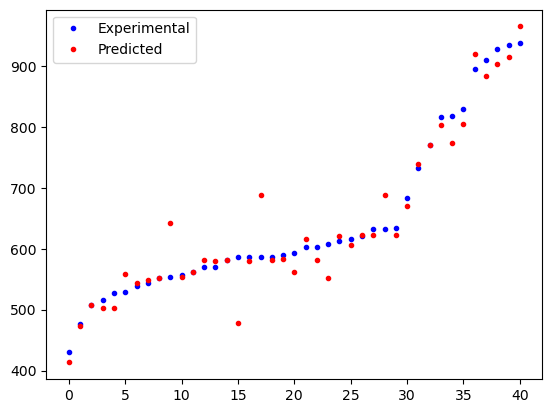

In [118]:
# Decision Tree model with 5 folds cross validation.
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error


nruns = 1
nfolds = 5

PearsonCC = np.zeros((nruns, nfolds))
R2_score = np.zeros_like(PearsonCC)
MSE = np.zeros_like(PearsonCC)
MAE = np.zeros_like(PearsonCC)

for j in range(nruns):

        kf = KFold(n_splits=nfolds, shuffle=True, random_state=123+j)

        for i, (tr, ts) in enumerate(kf.split(targets)):

            # Display the run number
            print('Run #', j+1, "Fold #", i+1)

            x_train, x_test = features.iloc[tr], features.iloc[ts]
            y_train, y_test = targets[tr], targets[ts]

            scale = StandardScaler()
            x_train = scale.fit_transform(x_train)
            x_test = scale.transform(x_test)

            y_train_log = np.log10(y_train)
            y_test_log = np.log10(y_test)

            # Initialize the Decision Tree Regressor
            regressor = DecisionTreeRegressor()

            # Train the model
            regressor.fit(x_train, y_train_log)

            # Make predictions on the testing set
            y_pred = 10**(regressor.predict(x_test))

            # Evaluation
            R2_score[j, i] = r2_score(y_test, y_pred)
            PearsonCC[j, i] =  pearsonr(y_test, np.squeeze(y_pred))[0]
            MSE[j, i] = np.sqrt(mean_squared_error(y_test, y_pred))
            MAE[j, i] = mean_absolute_error(y_test, y_pred)

            print(f'Pearson CC: {PearsonCC[j, i]}')
            print(f'R2 score: {R2_score[j, i]}')
            print(f'RMSE: {MSE[j, i]}')
            print(f'MAE: {MAE[j, i]}')


            # Parity plot, actual versus predicted values
            plt.plot(y_test, y_pred, 'k.')
            bounds = (min(y_test.min(), y_pred.min()) - 0.1*y_pred.min(), max(y_test.max(), y_pred.max())+ 0.1 * y_pred.max())
            plt.plot([bounds[0], bounds[1]], [bounds[0], bounds[1]],'b-', linewidth=0.5, label="Parity Line") # identity line
            plt.xlabel("Experimental ", fontsize=10)
            plt.ylabel("Predicted ", fontsize=10)
            plt.show()

            plt.plot(np.array(y_test), 'b.', label='Experimental')
            plt.plot(np.array(y_pred), 'r.', label='Predicted')
            plt.legend()
            plt.show()



In [119]:
# Data frame
df1 = pd.DataFrame({'Pearson CC': PearsonCC.flatten(), 'R2 Score': R2_score.flatten(), 'MSE': MSE.flatten(),
                    'MAE': MAE.flatten()},index=None)
df1

,Pearson CC,R2 Score,MSE,MAE
0,0.939335,0.868537,55.711907,32.629279
1,0.920258,0.832149,48.527940,29.755922
2,0.919021,0.824141,59.753407,34.232516
3,0.900317,0.809322,57.381083,31.397051
4,0.968702,0.936738,33.634138,21.648858


In [120]:
# Calculate mean values and standard deviations of the scores
PearsonCC_mean = np.mean(PearsonCC)
R2_score_mean = np.mean(R2_score)
MSE_mean = np.mean(MSE)
MAE_mean = np.mean(MAE)

PearsonCC_std = np.std(PearsonCC)
R2_score_std = np.std(R2_score)
MSE_std = np.std(MSE)
MAE_std = np.std(MAE)

# Data frame
df2 = pd.DataFrame({'Pearson CC Mean': PearsonCC_mean, 'Pearson CC Std': PearsonCC_std, 'R2 Score Mean': R2_score_mean, 'R2 Score Std': R2_score_std,
                  'MSE Mean': MSE_mean, 'MSE Std': MSE_std, 'MAE Mean': MAE_mean, 'MAE Std':MAE_std },index=[0])

df2

,Pearson CC Mean,Pearson CC Std,R2 Score Mean,R2 Score Std,MSE Mean,MSE Std,MAE Mean,MAE Std
0,0.929527,0.023153,0.854178,0.045655,51.001695,9.457554,29.932725,4.394487


Run # 1 Fold # 1
Pearson CC: 0.8347709727370825
R2 score: 0.5914705559183637
RMSE: 98.21067165980205
MAE: 84.90297920040791


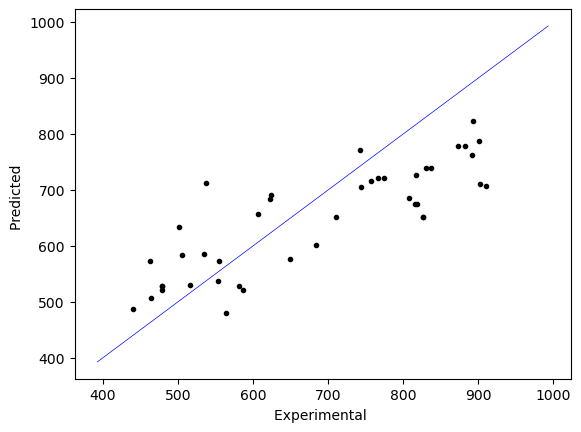

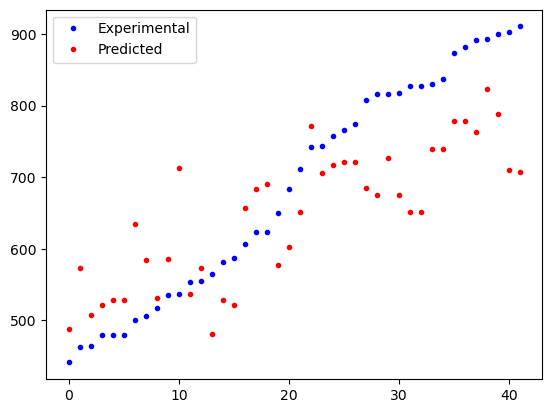

Run # 1 Fold # 2
Pearson CC: 0.87195897660617
R2 score: 0.6034893318980069
RMSE: 74.5859640711179
MAE: 58.27387906815129


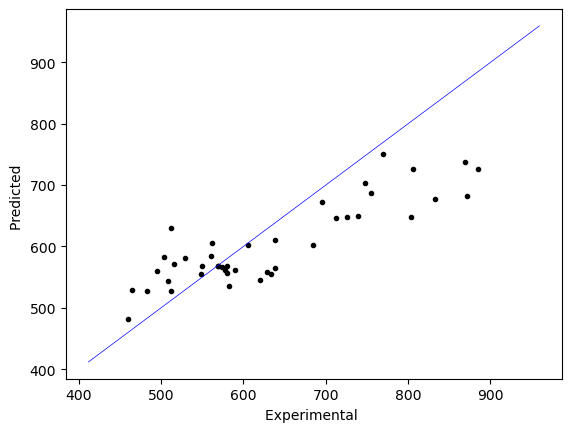

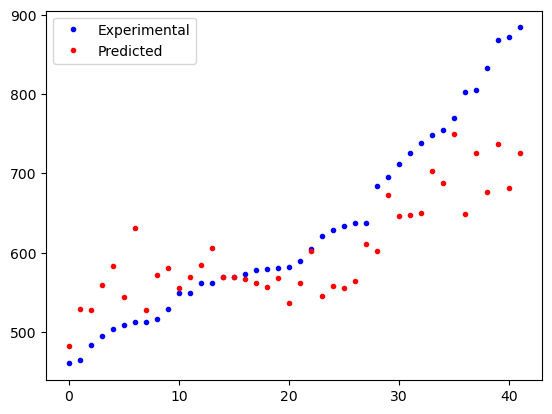

Run # 1 Fold # 3
Pearson CC: 0.7814991845255425
R2 score: 0.49463969817864495
RMSE: 101.2934680881898
MAE: 81.39635149852624


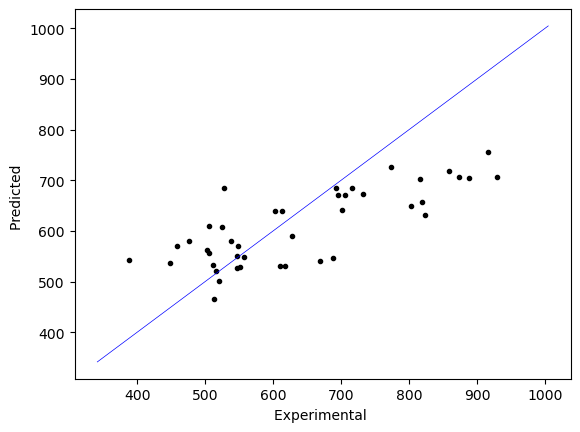

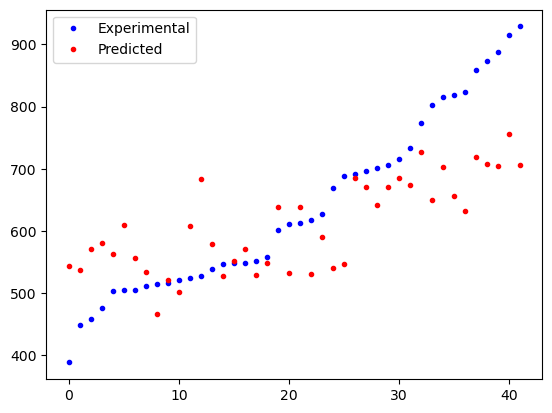

Run # 1 Fold # 4
Pearson CC: 0.7875536664122371
R2 score: 0.5570422401667124
RMSE: 87.45799098287212
MAE: 76.97214157976244


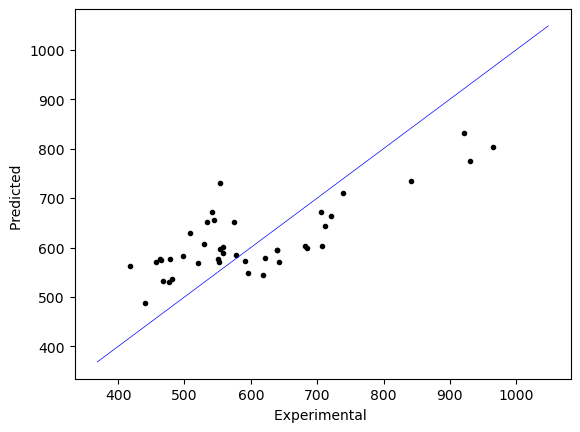

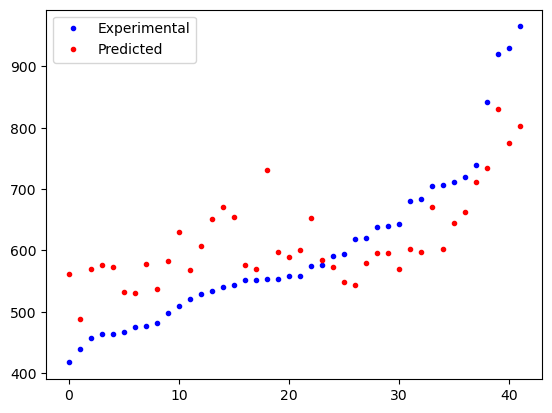

Run # 1 Fold # 5
Pearson CC: 0.8233972522399965
R2 score: 0.5759814054879417
RMSE: 87.07651187355015
MAE: 67.99035556286546


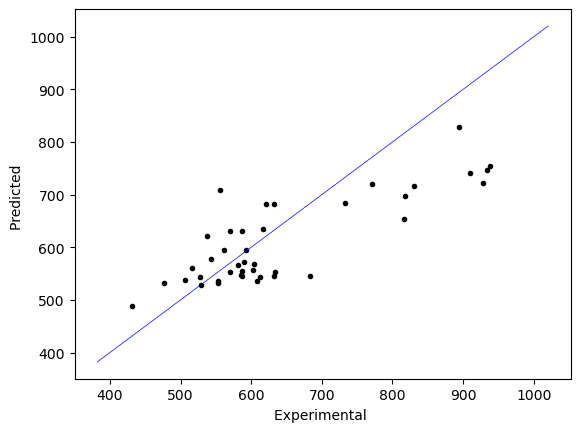

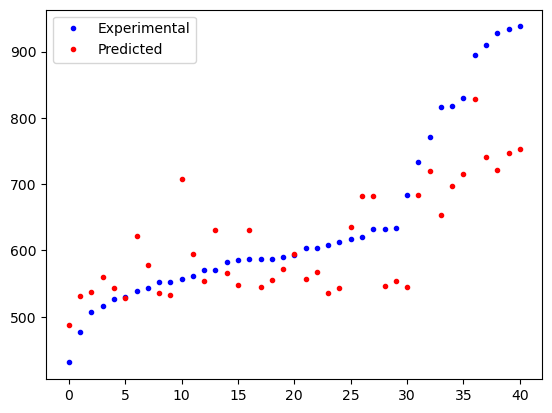

In [121]:
# SVM with 5 folds cross validation.

from sklearn.svm import SVR

nruns = 1
nfolds = 5

PearsonCC = np.zeros((nruns, nfolds))
R2_score = np.zeros_like(PearsonCC)
MSE = np.zeros_like(PearsonCC)
MAE = np.zeros_like(PearsonCC)

for j in range(nruns):

        kf = KFold(n_splits=nfolds, shuffle=True, random_state=123+j)

        for i, (tr, ts) in enumerate(kf.split(targets)):

            # Display the run number
            print('Run #', j+1, "Fold #", i+1)

            x_train, x_test = features.iloc[tr], features.iloc[ts]
            y_train, y_test = targets[tr], targets[ts]

            scale = StandardScaler()
            x_train = scale.fit_transform(x_train)
            x_test = scale.transform(x_test)

            y_train_log = np.log10(y_train)
            y_test_log = np.log10(y_test)

            svm_regressor = SVR(kernel='linear')

            svm_regressor.fit(x_train, y_train_log)

            y_pred = 10**(svm_regressor.predict(x_test))

            # Evaluation
            R2_score[j, i] = r2_score(y_test, y_pred)
            PearsonCC[j, i] =  pearsonr(y_test, np.squeeze(y_pred))[0]
            MSE[j, i] = np.sqrt(mean_squared_error(y_test, y_pred))
            MAE[j, i] = mean_absolute_error(y_test, y_pred)

            print(f'Pearson CC: {PearsonCC[j, i]}')
            print(f'R2 score: {R2_score[j, i]}')
            print(f'RMSE: {MSE[j, i]}')
            print(f'MAE: {MAE[j, i]}')


            # Parity plot, actual versus predicted values
            plt.plot(y_test, y_pred, 'k.')
            bounds = (min(y_test.min(), y_pred.min()) - 0.1*y_pred.min(), max(y_test.max(), y_pred.max())+ 0.1 * y_pred.max())
            plt.plot([bounds[0], bounds[1]], [bounds[0], bounds[1]],'b-', linewidth=0.5, label="Parity Line") # identity line
            plt.xlabel("Experimental ", fontsize=10)
            plt.ylabel("Predicted ", fontsize=10)
            plt.show()

            plt.plot(np.array(y_test), 'b.', label='Experimental')
            plt.plot(np.array(y_pred), 'r.', label='Predicted')
            plt.legend()
            plt.show()



In [122]:
# Data frame
df1 = pd.DataFrame({'Pearson CC': PearsonCC.flatten(), 'R2 Score': R2_score.flatten(), 'MSE': MSE.flatten(),
                    'MAE': MAE.flatten()},index=None)
df1

,Pearson CC,R2 Score,MSE,MAE
0,0.834771,0.591471,98.210672,84.902979
1,0.871959,0.603489,74.585964,58.273879
2,0.781499,0.494640,101.293468,81.396351
3,0.787554,0.557042,87.457991,76.972142
4,0.823397,0.575981,87.076512,67.990356


In [123]:
# Calculate mean values and standard deviations of the scores
PearsonCC_mean = np.mean(PearsonCC)
R2_score_mean = np.mean(R2_score)
MSE_mean = np.mean(MSE)
MAE_mean = np.mean(MAE)

PearsonCC_std = np.std(PearsonCC)
R2_score_std = np.std(R2_score)
MSE_std = np.std(MSE)
MAE_std = np.std(MAE)

# Data frame
df2 = pd.DataFrame({'Pearson CC Mean': PearsonCC_mean, 'Pearson CC Std': PearsonCC_std, 'R2 Score Mean': R2_score_mean, 'R2 Score Std': R2_score_std,
                  'MSE Mean': MSE_mean, 'MSE Std': MSE_std, 'MAE Mean': MAE_mean, 'MAE Std':MAE_std },index=[0])

df2

,Pearson CC Mean,Pearson CC Std,R2 Score Mean,R2 Score Std,MSE Mean,MSE Std,MAE Mean,MAE Std
0,0.819836,0.033059,0.564525,0.03825,89.724921,9.457064,73.907141,9.651924


Run # 1 Fold # 1
Pearson CC: 0.9368601726000791
R2 score: 0.8760213343042645
RMSE: 54.1028917857043
MAE: 31.640737558899133


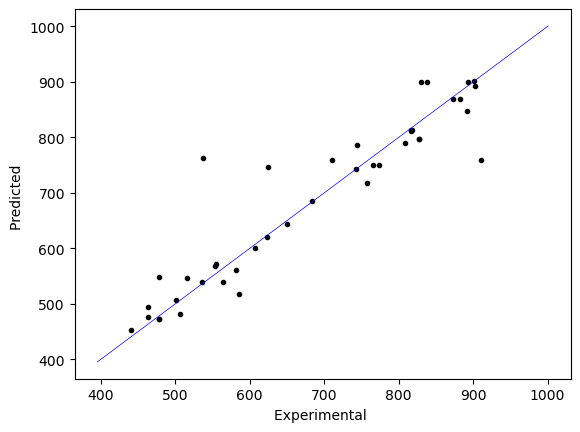

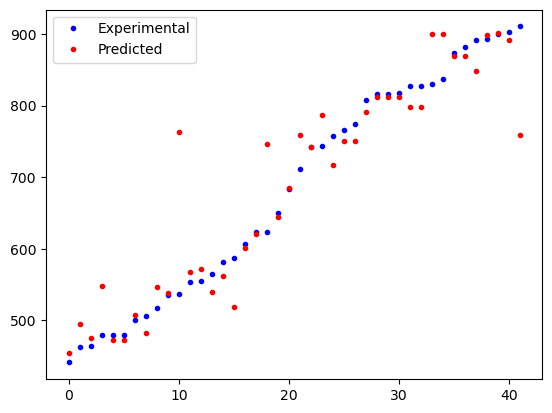

Run # 1 Fold # 2
Pearson CC: 0.9262844201544944
R2 score: 0.8402671188581339
RMSE: 47.3398450399446
MAE: 28.570691409568184


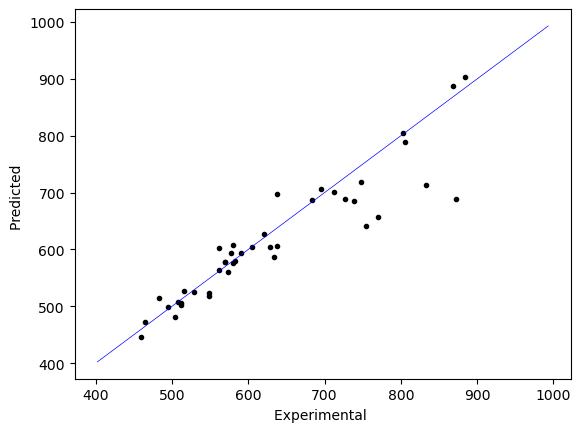

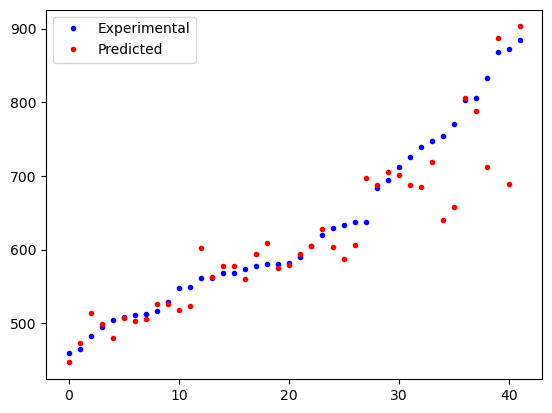

Run # 1 Fold # 3
Pearson CC: 0.8933524197830688
R2 score: 0.7924401181524631
RMSE: 64.91612480549017
MAE: 37.81520970550274


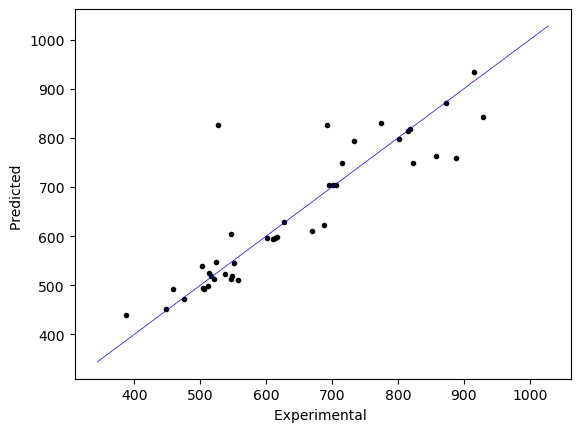

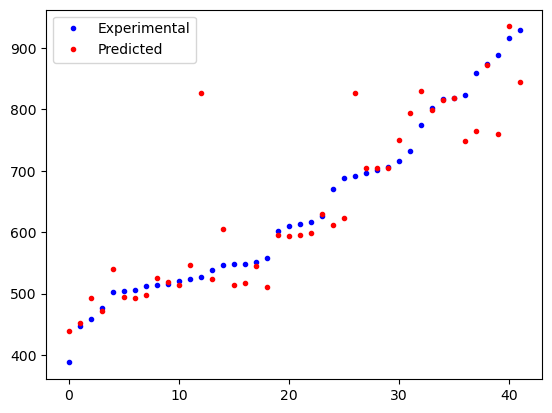

Run # 1 Fold # 4
Pearson CC: 0.938914119615869
R2 score: 0.8750858806549054
RMSE: 46.4434106113331
MAE: 33.7993849352862


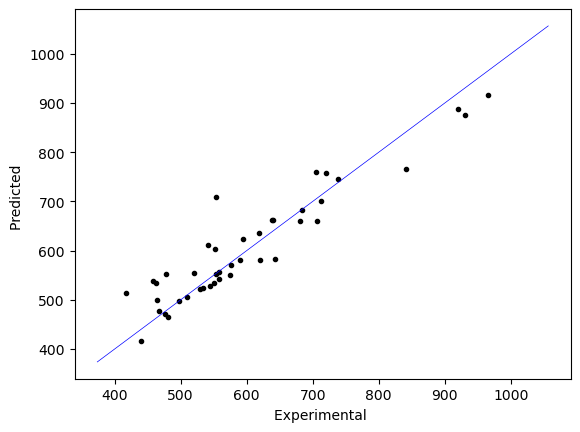

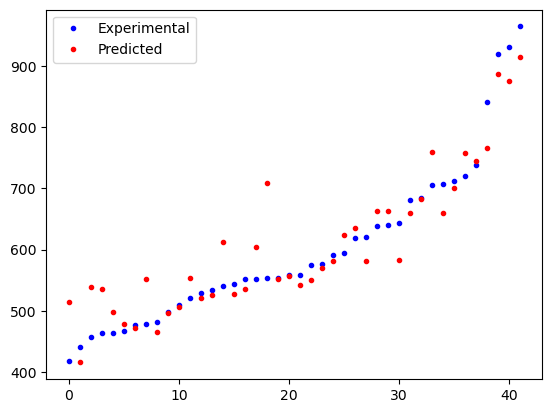

Run # 1 Fold # 5
Pearson CC: 0.9720201465196319
R2 score: 0.941226079843104
RMSE: 32.4190961086525
MAE: 24.047762622910806


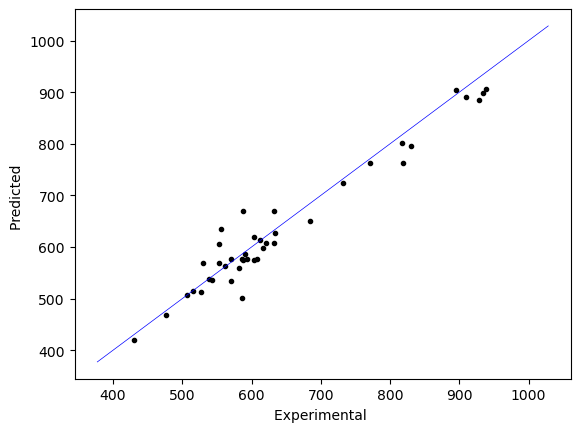

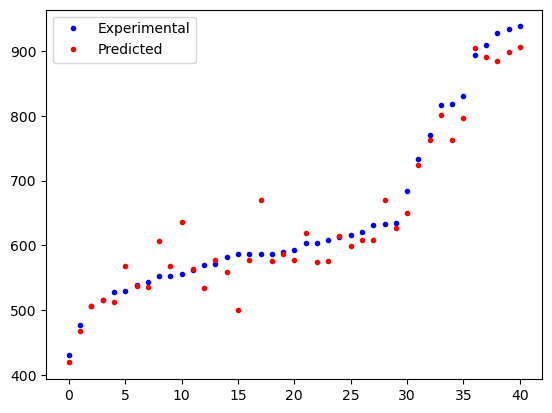

In [124]:
# Random Forest Model
from sklearn.ensemble import RandomForestRegressor

nruns = 1
nfolds = 5

PearsonCC = np.zeros((nruns, nfolds))
R2_score = np.zeros_like(PearsonCC)
MSE = np.zeros_like(PearsonCC)
MAE = np.zeros_like(PearsonCC)

for j in range(nruns):

        kf = KFold(n_splits=nfolds, shuffle=True, random_state=123+j)

        for i, (tr, ts) in enumerate(kf.split(targets)):

            # Display the run number
            print('Run #', j+1, "Fold #", i+1)

            x_train, x_test = features.iloc[tr], features.iloc[ts]
            y_train, y_test = targets[tr], targets[ts]

            scale = StandardScaler()
            x_train = scale.fit_transform(x_train)
            x_test = scale.transform(x_test)

            y_train_log = np.log10(y_train)
            y_test_log = np.log10(y_test)

            # Initialize Random Forest Regressor
            rf_regressor = RandomForestRegressor(n_estimators=10000, random_state=123)
            # Train the model
            rf_regressor.fit(x_train, y_train_log)

            # Make predictions on the testing set
            y_pred = 10**(rf_regressor.predict(x_test))

            # Evaluation
            R2_score[j, i] = r2_score(y_test, y_pred)
            PearsonCC[j, i] =  pearsonr(y_test, np.squeeze(y_pred))[0]
            MSE[j, i] = np.sqrt(mean_squared_error(y_test, y_pred))
            MAE[j, i] = mean_absolute_error(y_test, y_pred)

            print(f'Pearson CC: {PearsonCC[j, i]}')
            print(f'R2 score: {R2_score[j, i]}')
            print(f'RMSE: {MSE[j, i]}')
            print(f'MAE: {MAE[j, i]}')

            # Parity plot, actual versus predicted values
            plt.plot(y_test, y_pred, 'k.')
            bounds = (min(y_test.min(), y_pred.min()) - 0.1*y_pred.min(), max(y_test.max(), y_pred.max())+ 0.1 * y_pred.max())
            plt.plot([bounds[0], bounds[1]], [bounds[0], bounds[1]],'b-', linewidth=0.5, label="Parity Line") # identity line
            plt.xlabel("Experimental ", fontsize=10)
            plt.ylabel("Predicted ", fontsize=10)
            plt.show()

            plt.plot(np.array(y_test), 'b.', label='Experimental')
            plt.plot(np.array(y_pred), 'r.', label='Predicted')
            plt.legend()
            plt.show()


In [125]:
# Data frame
df1 = pd.DataFrame({'Pearson CC': PearsonCC.flatten(), 'R2 Score': R2_score.flatten(), 'MSE': MSE.flatten(),
                    'MAE': MAE.flatten()},index=None)
df1

,Pearson CC,R2 Score,MSE,MAE
0,0.936860,0.876021,54.102892,31.640738
1,0.926284,0.840267,47.339845,28.570691
2,0.893352,0.792440,64.916125,37.815210
3,0.938914,0.875086,46.443411,33.799385
4,0.972020,0.941226,32.419096,24.047763


In [126]:
# Calculate mean values and standard deviations of the scores
PearsonCC_mean = np.mean(PearsonCC)
R2_score_mean = np.mean(R2_score)
MSE_mean = np.mean(MSE)
MAE_mean = np.mean(MAE)

PearsonCC_std = np.std(PearsonCC)
R2_score_std = np.std(R2_score)
MSE_std = np.std(MSE)
MAE_std = np.std(MAE)

# Data frame
df2 = pd.DataFrame({'Pearson CC Mean': PearsonCC_mean, 'Pearson CC Std': PearsonCC_std, 'R2 Score Mean': R2_score_mean, 'R2 Score Std': R2_score_std,
                  'MSE Mean': MSE_mean, 'MSE Std': MSE_std, 'MAE Mean': MAE_mean, 'MAE Std':MAE_std },index=[0])

df2

,Pearson CC Mean,Pearson CC Std,R2 Score Mean,R2 Score Std,MSE Mean,MSE Std,MAE Mean,MAE Std
0,0.933486,0.025252,0.865008,0.048806,49.044274,10.616698,31.174757,4.66426


In [127]:
# K nearest neighbors model with 5 folds cross validation.
from sklearn.neighbors import KNeighborsRegressor



nruns = 1
nfolds = 5

PearsonCC = np.zeros((nruns, nfolds))
R2_score = np.zeros_like(PearsonCC)
MSE = np.zeros_like(PearsonCC)
MAE = np.zeros_like(PearsonCC)
for n in range (1,11):
    print('k-neighbor:'+ str(n) )
    for j in range(nruns):

            kf = KFold(n_splits=nfolds, shuffle=True, random_state=123+j)

            for i, (tr, ts) in enumerate(kf.split(targets)):

                # Display the run number
                print('Run #', j+1, "Fold #", i+1)

                x_train, x_test = features.iloc[tr], features.iloc[ts]
                y_train, y_test = targets[tr], targets[ts]

                scale = StandardScaler()
                x_train = scale.fit_transform(x_train)
                x_test = scale.transform(x_test)

                y_train_log = np.log10(y_train)
                y_test_log = np.log10(y_test)

                # Initialize KNeighborsRegressor
                knn_regressor = KNeighborsRegressor(n_neighbors=n)  # You can adjust the number of neighbors (k)

                # Train the model
                knn_regressor.fit(x_train, y_train_log)

                # Make predictions on the testing set
                y_pred = 10**(knn_regressor.predict(x_test))

                # Evaluation
                R2_score[j, i] = r2_score(y_test, y_pred)
                PearsonCC[j, i] =  pearsonr(y_test, np.squeeze(y_pred))[0]
                MSE[j, i] = np.sqrt(mean_squared_error(y_test, y_pred))
                MAE[j, i] = mean_absolute_error(y_test, y_pred)

                print(f'Pearson CC: {PearsonCC[j, i]}')
                print(f'R2 score: {R2_score[j, i]}')
                print(f'RMSE: {MSE[j, i]}')
                print(f'MAE: {MAE[j, i]}')


        # # Data frame
    df1 = pd.DataFrame({'Pearson CC': PearsonCC.flatten(), 'R2 Score': R2_score.flatten(), 'MSE': MSE.flatten(),
                        'MAE': MAE.flatten()},index=None)
        # Calculate mean values and standard deviations of the scores
    PearsonCC_mean = np.mean(PearsonCC)
    R2_score_mean = np.mean(R2_score)
    MSE_mean = np.mean(MSE)
    MAE_mean = np.mean(MAE)

    PearsonCC_std = np.std(PearsonCC)
    R2_score_std = np.std(R2_score)
    MSE_std = np.std(MSE)
    MAE_std = np.std(MAE)

    # Data frame
    df2 = pd.DataFrame({'Pearson CC Mean': PearsonCC_mean, 'Pearson CC Std': PearsonCC_std, 'R2 Score Mean': R2_score_mean, 'R2 Score Std': R2_score_std,
                    'MSE Mean': MSE_mean, 'MSE Std': MSE_std, 'MAE Mean': MAE_mean, 'MAE Std':MAE_std },index=[0])

    print(df2)



k-neighbor:1
Run # 1 Fold # 1
Pearson CC: 0.889148553257241
R2 score: 0.7360734219378922
RMSE: 78.93844429275923
MAE: 45.49420708504334
Run # 1 Fold # 2
Pearson CC: 0.8703090573108725
R2 score: 0.7091090885816576
RMSE: 63.884389013537984
MAE: 36.60532142166308
Run # 1 Fold # 3
Pearson CC: 0.8724536837899878
R2 score: 0.7341459437387701
RMSE: 73.46872865169946
MAE: 42.34602511062342
Run # 1 Fold # 4
Pearson CC: 0.859682322235843
R2 score: 0.7011964967099944
RMSE: 71.830879217548
MAE: 40.664019922208915
Run # 1 Fold # 5
Pearson CC: 0.9299027771205486
R2 score: 0.8551692097043755
RMSE: 50.89077009970313
MAE: 30.093969100662477
   Pearson CC Mean  Pearson CC Std  R2 Score Mean  R2 Score Std   MSE Mean  \
0         0.884299        0.024679       0.747139      0.055711  67.802642   

    MSE Std   MAE Mean   MAE Std  
0  9.733462  39.040709  5.313815  
k-neighbor:2
Run # 1 Fold # 1
Pearson CC: 0.8880652913658735
R2 score: 0.7800588140603539
RMSE: 72.06099938622191
MAE: 51.920264751976966
Run

In [128]:
# Define MyDataset object to feed the input data to the model.
class MyDataset(Dataset):
    def __init__(self, data, targets):
        self.features = data
        self.labels = targets

    def __len__(self):
        return self.features.shape[0]

    def __getitem__(self, idx):
        feature = self.features[idx]
        label = self.labels[idx]

        return feature, label

In [130]:
# Evaluate multiple runs of the model
nruns = 1
nfolds = 5

# Metrics for performance evaluation
PearsonCC = np.zeros((nruns, nfolds))
R2_score = np.zeros_like(PearsonCC)
RMSE = np.zeros_like(PearsonCC)
MAE = np.zeros_like(PearsonCC)

test_coverage = np.zeros_like(PearsonCC)
upper_coverage = np.zeros_like(PearsonCC)
lower_coverage = np.zeros_like(PearsonCC)
mean_interval_width = np.zeros_like(PearsonCC)
median_interval_width = np.zeros_like(PearsonCC)
composite_metric = np.zeros_like(PearsonCC)

for j in range(nruns):

        kf = KFold(n_splits=nfolds, shuffle=True, random_state=123+j)

        for i, (tr, ts) in enumerate(kf.split(targets)):

            x_train, x_test = features.iloc[tr], features.iloc[ts]
            y_train, y_test = targets[tr], targets[ts]

            # normalized features to the [0,1] range
            scaler = StandardScaler()
            x_train = scaler.fit_transform(x_train)
            x_test = scaler.transform(x_test)

            x_train = x_train.astype(dtype=np.float32)
            x_test = x_test.astype(np.float32)
            y_train_np = y_train.to_numpy(dtype=np.float32)
            y_test_np =  y_test.to_numpy(dtype=np.float32)

            x_train = torch.from_numpy(x_train)
            y_train = torch.from_numpy(y_train_np)

            x_test = torch.from_numpy(x_test)
            y_test = torch.from_numpy(y_test_np)

            train_dataset = MyDataset(x_train, y_train)
            train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=16)

            # define DNN
            class MLP(nn.Module):
                  def __init__(self, input_dim=38, output_dim=1, hidden_dim=10, n_hidden_layers=1, use_dropout=False):
                        super().__init__()

                        self.use_dropout = use_dropout
                        if use_dropout:
                              self.dropout = nn.Dropout(p=0.25)
                        self.activation = nn.ReLU()

                        # dynamically define architecture
                        self.layer_sizes = [input_dim] + n_hidden_layers * [hidden_dim] + [output_dim]
                        layer_list = [nn.Linear(self.layer_sizes[idx - 1], self.layer_sizes[idx]) for idx in
                                    range(1, len(self.layer_sizes))]
                        self.layers = nn.ModuleList(layer_list)

                  def forward(self, input):
                        hidden = self.activation(self.layers[0](input))
                        for layer in self.layers[1:-1]:
                              hidden_temp = self.activation(layer(hidden))

                              if self.use_dropout:
                                    hidden_temp = self.dropout(hidden_temp)

                              hidden = hidden_temp + hidden  # residual connection

                        output_mean = self.layers[-1](hidden).squeeze()
                        return output_mean

            def train(net, train_dataloader):
                  optimizer = torch.optim.Adam(params=net.parameters(), lr=0.01)
                  criterion = nn.MSELoss()

                  progress_bar = trange(3000)
                  for _ in progress_bar:
                        for i, data in enumerate(train_dataloader):
                              traning_data, training_label = data
                              optimizer.zero_grad()
                              y_pred = net(torch.Tensor(traning_data))
                              loss = criterion(y_pred.squeeze(), torch.Tensor(training_label))
                              progress_bar.set_postfix(loss=f'{loss / features.shape[0]:.3f}')
                              loss.backward()
                              optimizer.step()
                  return net

            # training
            net = MLP(hidden_dim=300, n_hidden_layers=3, use_dropout=True)

            train(net, train_dataloader)

            print("Run # ", j+1, "Fold #", i+1)

            # inference
            y_pred = np.array(net(torch.Tensor(x_test)).clone().detach().numpy())

            ## Metrics for evaluating the predictive accuracy of the model
            PearsonCC[j, i] = pearsonr(np.squeeze(y_test), np.squeeze(y_pred))[0]
            R2_score[j, i] = r2_score(y_test, y_pred)
            RMSE[j, i] = np.sqrt(mean_squared_error(y_pred, y_test))
            MAE[j, i] = np.mean(abs(y_pred-np.array(y_test)))

            print(f'Pearson CC: {PearsonCC[j, i]}')
            print(f'R2 score: {R2_score[j, i]}')
            print(f'RMSE: {RMSE[j, i]}')
            print(f'MAE: {MAE[j, i]}')

  0%|          | 0/3000 [00:00<?, ?it/s]

Run #  1 Fold # 1
Pearson CC: 0.9300217290021858
R2 score: 0.8555260742974575
RMSE: 58.40388488769531
MAE: 36.06978988647461


  0%|          | 0/3000 [00:00<?, ?it/s]

Run #  1 Fold # 2
Pearson CC: 0.892862755258972
R2 score: 0.7834810256054222
RMSE: 55.11599349975586
MAE: 31.7001953125


  0%|          | 0/3000 [00:00<?, ?it/s]

Run #  1 Fold # 3
Pearson CC: 0.8793581228305253
R2 score: 0.7513608784855863
RMSE: 71.05025482177734
MAE: 39.528865814208984


  0%|          | 0/3000 [00:00<?, ?it/s]

Run #  1 Fold # 4
Pearson CC: 0.8781311241479409
R2 score: 0.7411188203354231
RMSE: 66.86033630371094
MAE: 37.51988983154297


  0%|          | 0/3000 [00:00<?, ?it/s]

Run #  1 Fold # 5
Pearson CC: 0.814189330048493
R2 score: 0.5902838539406738
RMSE: 85.5953369140625
MAE: 34.96927261352539


In [131]:
# Data frame
df1 = pd.DataFrame({'Pearson CC': PearsonCC.flatten(), 'R2 Score': R2_score.flatten(), 'RMSE': RMSE.flatten(),
                    'MAE': MAE.flatten(), 'Coverage': test_coverage.flatten()},index=None)
df1

,Pearson CC,R2 Score,RMSE,MAE,Coverage
0,0.930022,0.855526,58.403885,36.069790,0.0
1,0.892863,0.783481,55.115993,31.700195,0.0
2,0.879358,0.751361,71.050255,39.528866,0.0
3,0.878131,0.741119,66.860336,37.519890,0.0
4,0.814189,0.590284,85.595337,34.969273,0.0


In [132]:
# Calculate mean values and standard deviations of the scores
PearsonCC_mean = np.mean(PearsonCC)
R2_score_mean = np.mean(R2_score)
RMSE_mean = np.mean(RMSE)
MAE_mean = np.mean(MAE)


PearsonCC_std = np.std(PearsonCC)
R2_score_std = np.std(R2_score)
RMSE_std = np.std(RMSE)
MAE_std = np.std(MAE)


# Data frame
df2 = pd.DataFrame({'Pearson CC Mean': PearsonCC_mean, 'Pearson CC Std': PearsonCC_std, 'R2 Score Mean': R2_score_mean, 'R2 Score Std': R2_score_std,
                  'RMSE Mean': RMSE_mean, 'RMSE Std': RMSE_std, 'MAE Mean': MAE_mean, 'MAE Std':MAE_std,
                   'RMSE Std': RMSE_std},index=[0])
df2

,Pearson CC Mean,Pearson CC Std,R2 Score Mean,R2 Score Std,RMSE Mean,RMSE Std,MAE Mean,MAE Std
0,0.878913,0.037408,0.744354,0.086819,67.405161,10.737902,35.957603,2.619525
